In [1]:
#import os
#os.environ["CFLAGS"] = ""  # Clear any existing flags
#os.environ["CC"] = "gcc"
import os
# os.environ["CFLAGS"] = "-O2"  # Use a valid optimization level
# os.environ["CC"] = "/opt/homebrew/bin/gcc-14"  


import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# import package to draw bistable switches and utility functions
import changingswitches as cs
import csutils as csu

# Now import JitCDDE
from jitcdde import y as yd, t as td, jitcdde
from jitcdde import jitcdde
# from jitcdde.sympy_symbols import t as td, y as yd

In [2]:
! echo $CC

/opt/homebrew/bin/gcc-14


Generating, compiling, and loading C code.


/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcxde_common/_jitcxde.py:248: UserWarning: Differential equation does not include a delay term.
  self.compile_C()
clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcdde/_jitcdde.py:965: UserWarning: Traceback (most recent call last):
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcxde_common/_jitcxde.py", line 248, in _attempt_compilation
    self.compile_C()
    ~~~~~~~~~~~~~~^^
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcdde/_jitcdde.py", line 575, in compile_C
    self._compile_and_load(verbose,extra_compile_args,extra_link_args,omp)
    ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nao

Using default integration parameters.
Generating, compiling, and loading C code.


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcdde/_jitcdde.py:965: UserWarning: Traceback (most recent call last):
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcxde_common/_jitcxde.py", line 248, in _attempt_compilation
    self.compile_C()
    ~~~~~~~~~~~~~~^^
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcdde/_jitcdde.py", line 575, in compile_C
    self._compile_and_load(verbose,extra_compile_args,extra_link_args,omp)
    ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcxde_common/_jitcxde.py", line 320, in _compile_and_load
    self.jitced = find_and_load_module(self._modulename,self._tmpfi

Using default integration parameters.


/Users/naomiduggan/Desktop/dynamicswitches/changingswitches.py:185: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return fsolve(tosolve, [xt0,x0])
/Users/naomiduggan/Desktop/dynamicswitches/changingswitches.py:185: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(tosolve, [xt0,x0])


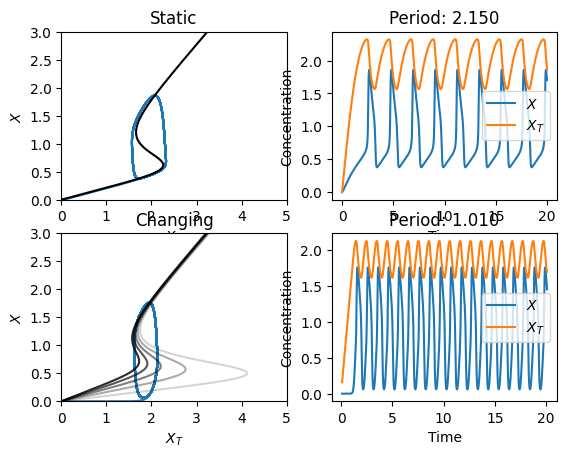

In [2]:


## Simulate
p = dict(b=1., K=1, n=5, ap=0.1, bp=1., Kp=1., m=5)

a = 0.3

# Hill functions
def f(x,a):
    return a +p['b']*x**p['n']/(p['K']**p['n'] + x**p['n'])
def g(x):
    return p['ap']+p['bp']*p['Kp']**p['m']/(p['Kp']**p['m'] + x**p['m'])



# compute switch
switch= cs.ResponseOneEnzymeXt(a=a,**p)
switchdat = []

switch.setcontpars(0.01,2000)
switch.setstart(0,0,[0.1,0.1])
switch.compute_responsecurve()


#Simulation for a system without noise, with possible time delay

tau = 0.1
kX = 1.6
kappa = 5.
epsilon = 0.05

# threshold value used in a(X_T)
Xc = 0.5*(switch.folds[0][0] + switch.folds[1][0])

def F(x, xc):
    #function which returns values between -1 and 1
    return sp.tanh(kappa*(x-xc))
def Fn(x, xc):
    return np.tanh(kappa*(x-xc))

fig, axes = plt.subplots(2,2)

# simulate once for a static, once for a changing switch
for i,da in enumerate([0, 0.3]):
    dxdt = [1/epsilon*(f(yd(0), a+da*F(yd(1,td-tau), Xc))*(yd(1)-yd(0))- g(yd(0))*yd(0)), kX-yd(1)*yd(0)]
    y0 = [0,0]
    ddesys = jitcdde(dxdt)
    ddesys.constant_past(y0)
    ddesys.step_on_discontinuities(max_step=0.01)
    ddesys.set_integration_parameters(first_step=0.001,max_step=0.01)

    timeseries = []

    tv = np.arange(ddesys.t, ddesys.t+20, 0.01)
    for time in tv:
        timeseries.append( ddesys.integrate(time) )

    timeseries = np.array(timeseries)
    Xv = timeseries[:,0]
    XTv = timeseries[:,1]
    if da > 0: # keep the a values for the changing switch, to use for plotting snapshots of the switch
        av = a + da*Fn(XTv,Xc)

    axes[i,0].plot(XTv,Xv)
    axes[i,1].plot(tv, Xv, label='$X$')
    axes[i,1].plot(tv, XTv, label='$X_T$')

    #detect period using two thresholds
    #thresholds are up and down
    ct = csu.getcrossingtimes_twothresholds(tv, Xv, switch.folds[1][1], switch.folds[0][1])
    if len(ct)>3:
        per2 = abs(ct[-1][0]-ct[-3][0])
    else:
        per2=0
    axes[i,1].set_title('Period: {:.3f}'.format(per2))


# add labels etc
for ax in axes[:,0]: # phaseplanes
    ax.set_xlabel('$X_T$')
    ax.set_ylabel('$X$')
    ax.set_xlim(0,5)
    ax.set_ylim(0,3)

# plot the switch curve for static switch
axes[0,0].plot(switch.xtv, switch.xv, 'k')

# plot snapshots for the changing switch
# use a range of a values in between min and max a attained in the limit cycle
n=6
lowa = np.min(av[-500:])
higha = np.max(av[-500:])

for i,aa in enumerate(np.linspace(lowa,higha,n)):
    switch.a=aa
    switch.compute_responsecurve()
    axes[1,0].plot(switch.xtv, switch.xv, color='k', alpha=i/n)

for ax in axes[:,1]: # time series
    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration')
    ax.legend()

axes[0,0].set_title('Static')
axes[1,0].set_title('Changing')

plt.show()

Generating, compiling, and loading C code.


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcdde/_jitcdde.py:965: UserWarning: Traceback (most recent call last):
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcxde_common/_jitcxde.py", line 248, in _attempt_compilation
    self.compile_C()
    ~~~~~~~~~~~~~~^^
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcdde/_jitcdde.py", line 575, in compile_C
    self._compile_and_load(verbose,extra_compile_args,extra_link_args,omp)
    ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcxde_common/_jitcxde.py", line 320, in _compile_and_load
    self.jitced = find_and_load_module(self._modulename,self._tmpfi

Using default integration parameters.
Generating, compiling, and loading C code.


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcdde/_jitcdde.py:965: UserWarning: Traceback (most recent call last):
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcxde_common/_jitcxde.py", line 248, in _attempt_compilation
    self.compile_C()
    ~~~~~~~~~~~~~~^^
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcdde/_jitcdde.py", line 575, in compile_C
    self._compile_and_load(verbose,extra_compile_args,extra_link_args,omp)
    ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/naomiduggan/Desktop/dynamicswitches/.venv/lib/python3.13/site-packages/jitcxde_common/_jitcxde.py", line 320, in _compile_and_load
    self.jitced = find_and_load_module(self._modulename,self._tmpfi

Using default integration parameters.


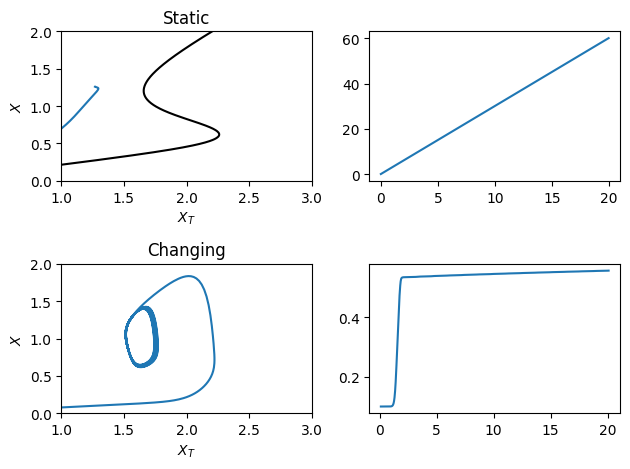

In [6]:
## Demo file for the code that was used in the paper
## Dynamic bistable switches enhance robustness and accuracy of cell cycle transitions
## by Jan Rombouts and Lendert Gelens


## Simulate
p = dict(b=1., K=1, n=5, ap=0.1, bp=1., Kp=1., m=5)

a = 0.3

# Hill functions
def f(x,a):
    return a +p['b']*x**p['n']/(p['K']**p['n'] + x**p['n'])
def g(x):
    return p['ap']+p['bp']*p['Kp']**p['m']/(p['Kp']**p['m'] + x**p['m'])

# compute switch
switch= cs.ResponseOneEnzymeXt(a=a,**p)
switchdat = []

switch.setcontpars(0.01,2000)
switch.setstart(0,0,[0.1,0.1])
switch.compute_responsecurve()


#Simulation for a system without noise, with possible time delay

tau = 0.1
# If the delay becomes shorter than the step size,
# we need a delayed state to evaluate f before we have
# a final result for the required interpolation anchors

kX = 1.6
kappa = 5.
epsilon = 0.05
delta = 0.1

# threshold value used in a(X_T)
Xc = 0.5*(switch.folds[0][0] + switch.folds[1][0])

def F(x, xc):
    #function which returns values between -1 and 1
    return sp.tanh(kappa*(x-xc))
def Fn(x, xc):
    return np.tanh(kappa*(x-xc))

fig, axes = plt.subplots(2,2)

# simulate once for a static, once for a changing switch
for i,da in enumerate([0, 0.3]):
    # dxdt = [1/epsilon*(f(yd(0), a+da*F(yd(1,td-tau), Xc))*(yd(1)-yd(0))- g(yd(0))*yd(0)), kX-yd(1)*yd(0)]
    dxdt = [
        1/epsilon*(f(yd(0), yd(2))*(yd(1)-yd(0))- g(yd(0))*yd(0)),
        kX-yd(1)*yd(0),
        1/delta*(a+da*F(yd(1,td-tau) - yd(2), Xc))
    ]
    
    # jitcdde takes a list of expressions for each dimensions: X and X_t in this case
    y0 = [0,0,0.1] # initial condition X=X_t=0, a=0?
    ddesys = jitcdde(dxdt)
    ddesys.constant_past(y0) # impose that for all t < 0, y(t) = y0
    ddesys.step_on_discontinuities(max_step=0.01)
    # avoids wrongful calculation of derivative near discontinuities
    ddesys.set_integration_parameters(first_step=0.001,max_step=0.01)

    timeseries = []

    tv = np.arange(ddesys.t, ddesys.t+20, 0.01)
    # ddesys.t queries the step_on_discontinuities adjusted t0 
    for time in tv: # integrate over time range
        timeseries.append( ddesys.integrate(time) )

    timeseries = np.array(timeseries)
    Xv = timeseries[:,0]
    XTv = timeseries[:,1]
    Xa = timeseries[:,2]
    
    # if da > 0: # keep the a values for the changing switch, to use for plotting snapshots of the switch
    #     av = a + da*Fn(XTv,Xc)

    axes[i,0].plot(XTv,Xv)
    # axes[i,1].plot(tv, Xv, label='$X$')
    axes[i,1].plot(tv, Xa)
    # axes[i,1].plot(tv, XTv, label='$X_T$')

    #detect period using two thresholds
    #thresholds are up and down
    # ct = csu.getcrossingtimes_twothresholds(tv, Xv, switch.folds[1][1], switch.folds[0][1])
    # if len(ct)>3:
    #     per2 = abs(ct[-1][0]-ct[-3][0])
    # else:
    #     per2=0
    # axes[i,1].set_title('Period: {:.3f}'.format(per2))


# add labels etc
for ax in axes[:,0]: # phaseplanes
    ax.set_xlabel('$X_T$')
    ax.set_ylabel('$X$')
    ax.set_xlim(1,3)
    ax.set_ylim(0,2)

# plot the switch curve for static switch
axes[0,0].plot(switch.xtv, switch.xv, 'k')

# plot snapshots for the changing switch
# use a range of a values in between min and max a attained in the limit cycle
n=6
lowa = np.min(av[-500:])
higha = np.max(av[-500:])

# for i,aa in enumerate(np.linspace(lowa,higha,n)):
#     switch.a=aa
#     switch.compute_responsecurve()
#     axes[1,0].plot(switch.xtv, switch.xv, color='k', alpha=i/n)

# for ax in axes[:,1]: # time series
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Concentration')
#     ax.legend()

axes[0,0].set_title('Static')
axes[1,0].set_title('Changing')
# axes[0,-]
plt.tight_layout()
plt.show()